<a href="https://colab.research.google.com/github/dineshRaja29/KNN/blob/main/knn_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##<font color='green'><b>INTRODUCTION </b></font>

<ol>
    <li><strong>Apply Knn (brute force version) on these feature sets</strong>
        <ul>
            <li></font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li></font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li></font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li></font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br>NOTE: sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
        </ul>
</ol>

##<font color='green'><b>DATASET </b></font>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.





The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [ ]:
display['COUNT(*)'].sum()

393063

##<font color='green'><b>PREPROCESSING

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64


Preprocessing
1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>



In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:34<00:00, 2528.74it/s]


In [ ]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

##<font color='green'><b>Featurization

###<font color='green'><b>BAG OF WORDS

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


####<font color='green'><b>Bi-Grams and n-Grams

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


###<font color='green'><b>TF-IDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


###<font color='green'><b>Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8491503596305847), ('awesome', 0.8405653834342957), ('good', 0.8301473259925842), ('excellent', 0.8109509944915771), ('terrific', 0.8074146509170532), ('wonderful', 0.7730129361152649), ('perfect', 0.7454617023468018), ('amazing', 0.7358652353286743), ('nice', 0.7245548367500305), ('decent', 0.7187523245811462)]
[('greatest', 0.7807512879371643), ('best', 0.7284427881240845), ('tastiest', 0.6810902953147888), ('nastiest', 0.6746965646743774), ('disgusting', 0.6406658887863159), ('horrible', 0.6192571520805359), ('terrible', 0.6101971864700317), ('awful', 0.6071272492408752), ('closest', 0.6023781895637512), ('freshest', 0.5998597741127014)]


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


####<font color='green'><b>Converting text into vectors using Avg W2V, TFIDF-W2V

#####<font color='green'><b>Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 87773/87773 [03:42<00:00, 394.91it/s]


87773
50


#####<font color='green'><b>TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [49:07<00:00, 29.78it/s]


In [ ]:
# Confusion matrix print function 
def ConfusionMatrixPrint(cm):
  class_label = ["negative", "positive"]
  df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
  sns.heatmap(df_cm, annot = True, fmt = "d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()
  
def ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr):
  plt.figure()
  plt.plot(fpr, tpr,label='Test ROC curve' ,
           color='darkorange', linestyle=':', linewidth=4)

  plt.plot(fpr_tr, tpr_tr,label='Train ROC curve',
           color='navy', linestyle=':', linewidth=4)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC CURVE ')
  plt.legend(loc="lower right")
  plt.show()

##<font color='green'><b>Applying KNN brute force

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [ ]:
X = preprocessed_reviews
y = final['Score']
print(len(X))
print(len(y))
print(y.value_counts())
# Random Splitting of data using train_test_split
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)



87773
87773
1    73592
0    14181
Name: Score, dtype: int64


### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 25
start = 1
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start)
  vectorizer =  CountVectorizer()
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)


Ranges of values from where we search for great penalty
 [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]


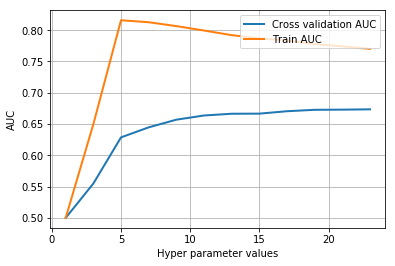

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### Building Model on Optimal Hyperparameter k=12

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 12 )
vectorizer =  CountVectorizer()
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
clf.fit(X_tr_bow, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=12, p=2,
           weights='uniform')

Confusion Matrix on Train 



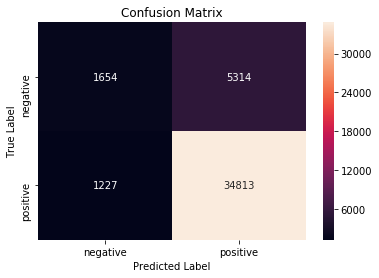

Confusion Matrix on Test 



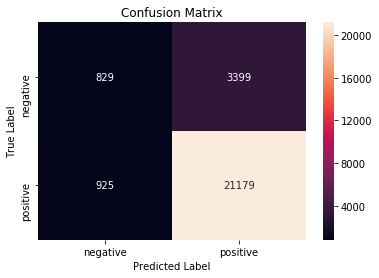

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.6605083592964334
**** TRAIN AUC *****  0.7962114843852538


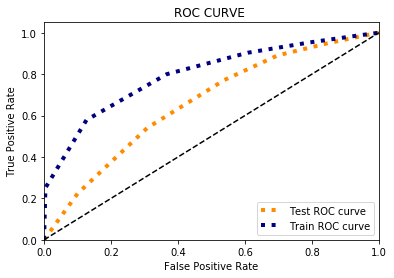

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 19
start = 1
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start)
  vectorizer =  TfidfVectorizer()
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)


Ranges of values from where we search for great penalty
 [1, 3, 5, 7, 9, 11, 13, 15, 17]


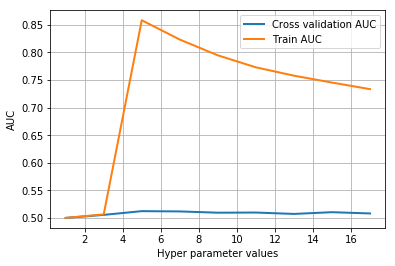

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### Building Model on optimal hyperaparameter k= 8

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 8 )
vectorizer =  CountVectorizer()
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
clf.fit(X_tr_bow, y_tr)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform')

Confusion Matrix on Train 



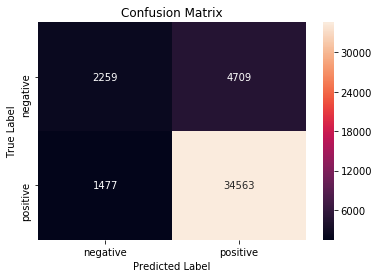

Confusion Matrix on Test 



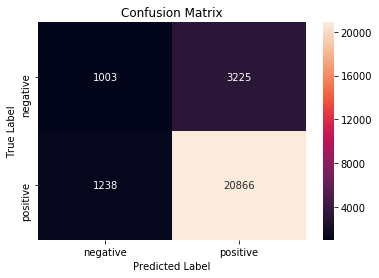

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.6488380720913025
**** TRAIN AUC *****  0.8089756737156444


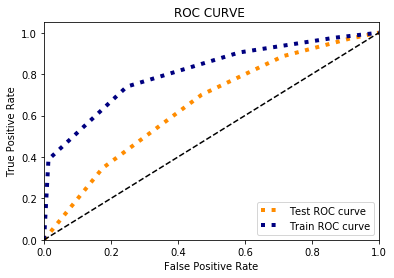

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

##### Generating our Word2Vec from Train Data

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)


In [ ]:
w2v_words = list(w2v_model.wv.vocab)
X_tr_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in (training_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_vectors.append(sent_vec)


In [ ]:
cv_words = []
for sentance in X_cv:
    cv_words.append(sentance.split())

X_cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in cv_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)


In [ ]:
test_words = []
for sentance in X_test:
    test_words.append(sentance.split())

X_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in test_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)

#### Buiding Model with hyperparameter tuning

In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 16
start = 1
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start)
  clf.fit(X_tr_vectors,y_tr)
  y_cv_predict = np.array(clf.predict_proba(X_cv_vectors))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)


Ranges of values from where we search for great penalty
 [1, 3, 5, 7, 9, 11, 13, 15]


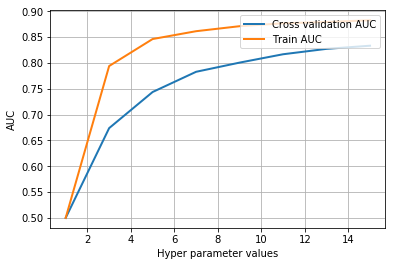

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### Optimal Hyperparameter is K = 13

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 13 )
clf.fit(X_tr_vectors, y_tr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')

Confusion Matrix on Train 



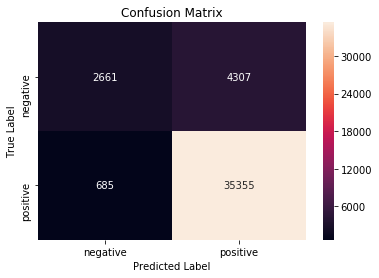

Confusion Matrix on Test 



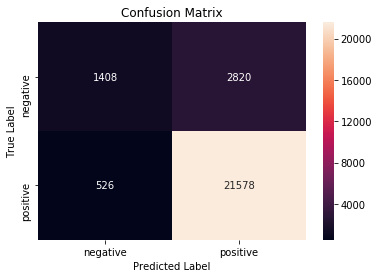

In [ ]:
predict = clf.predict(X_tr_vectors)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(X_test_vectors)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.8246424306306713
**** TRAIN AUC *****  0.8791812575738654


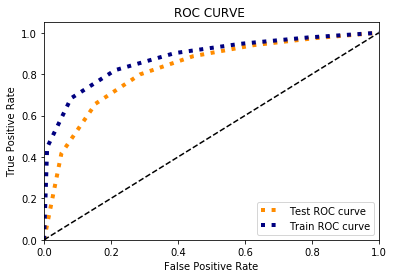

In [ ]:
y_cv_predict = np.array(clf.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)


In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [ ]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names


In [ ]:
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 43008/43008 [19:31<00:00, 36.71it/s]


In [ ]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 18433/18433 [08:13<00:00, 37.33it/s]


In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 26332/26332 [11:47<00:00, 37.23it/s]


In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 16
start = 3
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start)
  clf.fit(tfidf_sent_vectors_tr,y_tr)
  y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_cv))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)


Ranges of values from where we search for great penalty
 [3, 5, 7, 9, 11, 13, 15]


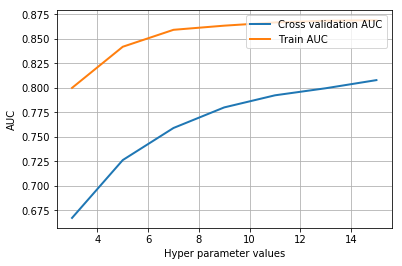

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### Optimal Hyperparameter is k = 8

Confusion Matrix on Train 



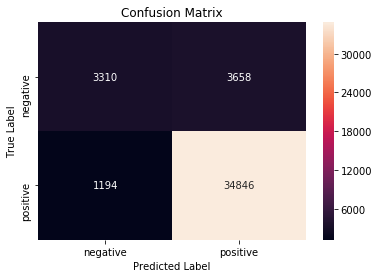

Confusion Matrix on Test 



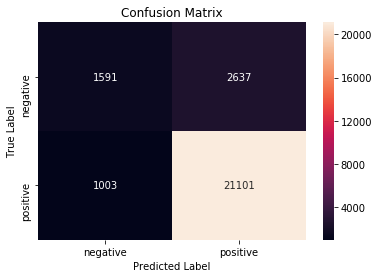

**** TEST AUC ***  0.7641608519338016
**** TRAIN AUC *****  0.861913314122846


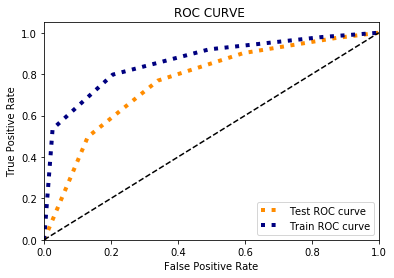

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 8 )
clf.fit(tfidf_sent_vectors_tr, y_tr)
predict = clf.predict(tfidf_sent_vectors_tr)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(tfidf_sent_vectors_test)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)


y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>Applying KNN kd-tree

In [ ]:
X = preprocessed_reviews[:20000]
y = final['Score']
y = y[:20000]
print(len(X))
print(len(y))
print(y.value_counts())
# Random Splitting of data using train_test_split
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)

20000
20000
1    16962
0     3038
Name: Score, dtype: int64


### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 16
start = 1
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start, algorithm = 'kd_tree')
  vectorizer =  CountVectorizer(min_df=10, max_features=500)
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  X_tr_bow = X_tr_bow.todense()
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  X_cv_bow = X_cv_bow.todense()
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)



Ranges of values from where we search for great penalty
 [1, 3, 5, 7, 9, 11, 13, 15]


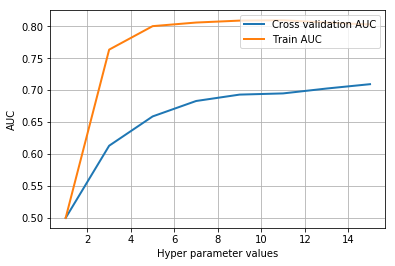

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### optimal hyperparameter value is k = 9

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 9, algorithm = 'kd_tree' )
vectorizer =  CountVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
X_tr_bow = X_tr_bow.todense()
clf.fit(X_tr_bow, y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

Confusion Matrix on Train 



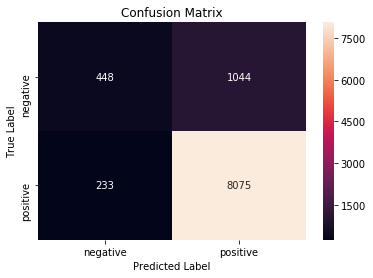

Confusion Matrix on Test 



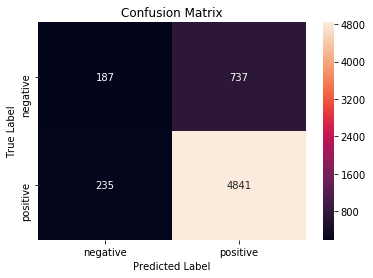

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
test_dtm = test_dtm.todense()
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)


**** TEST AUC ***  0.7039440973394874
**** TRAIN AUC *****  0.8087556278324712


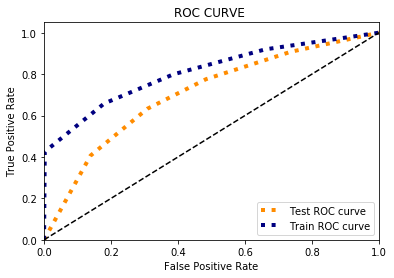

In [ ]:
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 16
start = 3
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start, algorithm = 'kd_tree')
  vectorizer =  TfidfVectorizer(min_df=10, max_features=500)
  vectorizer.fit(X_tr)
  X_tr_bow = vectorizer.transform(X_tr)
  X_tr_bow = X_tr_bow.todense()
  clf.fit(X_tr_bow,y_tr)
  X_cv_bow = vectorizer.transform(X_cv)
  X_cv_bow = X_cv_bow.todense()
  y_cv_predict = np.array(clf.predict_proba(X_cv_bow))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)

Ranges of values from where we search for great penalty
 [3, 5, 7, 9, 11, 13, 15]


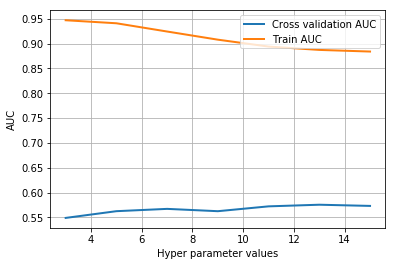

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### Building Model on optimal hyperparameter k=11

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 11 ,algorithm = 'kd_tree')
vectorizer =  TfidfVectorizer(min_df=10, max_features=500)
vectorizer.fit(X_tr)
X_tr_bow = vectorizer.transform(X_tr)
X_tr_bow = X_tr_bow.todense()
clf.fit(X_tr_bow, y_tr)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')

Confusion Matrix on Train 



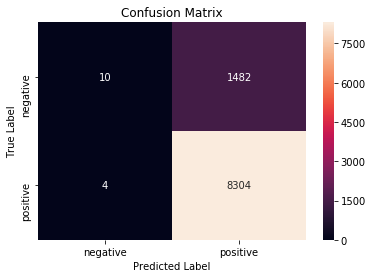

Confusion Matrix on Test 



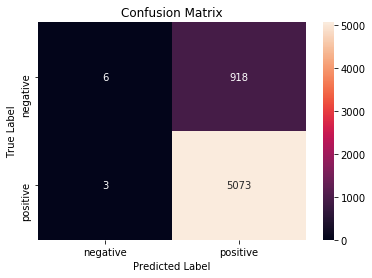

In [ ]:
predict = clf.predict(X_tr_bow)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
test_dtm = vectorizer.transform(X_test)
test_dtm = test_dtm.todense()
predict = clf.predict(test_dtm)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)

**** TEST AUC ***  0.5675547692391664
**** TRAIN AUC *****  0.8941475382750692


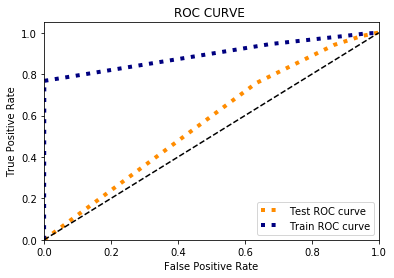

In [ ]:
y_cv_predict = np.array(clf.predict_proba(test_dtm))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_bow))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

#### Building our own word2vec

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
X_tr_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in (training_words): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_vectors.append(sent_vec)


In [ ]:
cv_words = []
for sentance in X_cv:
    cv_words.append(sentance.split())

X_cv_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in cv_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_cv_vectors.append(sent_vec)



In [ ]:
test_words = []
for sentance in X_test:
    test_words.append(sentance.split())

X_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# print(w2v_model.wv.vocab)
for sent in test_words: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_vectors.append(sent_vec)


In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 15
start = 1
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start,algorithm = 'kd_tree')
  clf.fit(X_tr_vectors,y_tr)
  y_cv_predict = np.array(clf.predict_proba(X_cv_vectors))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)


Ranges of values from where we search for great penalty
 [1, 3, 5, 7, 9, 11, 13]


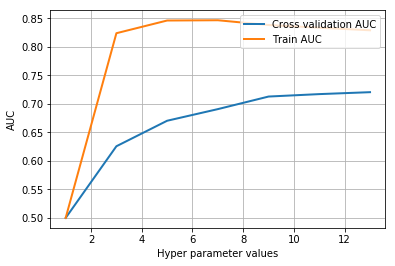

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### hyperparameter value k = 11

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 11 , algorithm  = 'kd_tree')
clf.fit(X_tr_vectors, y_tr)


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=11, p=2,
           weights='uniform')

Confusion Matrix on Train 



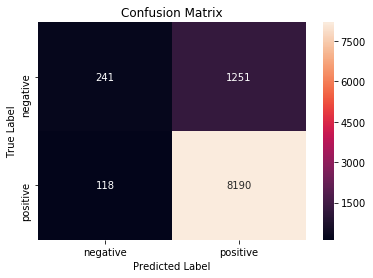

Confusion Matrix on Test 



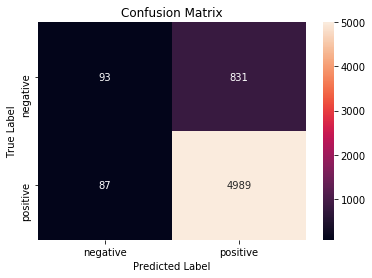

**** TEST AUC ***  0.7391401775267024
**** TRAIN AUC *****  0.8333791697269082


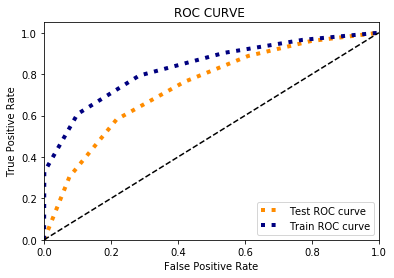

In [ ]:
predict = clf.predict(X_tr_vectors)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(X_test_vectors)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)


y_cv_predict = np.array(clf.predict_proba(X_test_vectors))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(X_tr_vectors))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
training_words = []
for sentance in X_tr:
    training_words.append(sentance.split())
w2v_model=Word2Vec(training_words,min_count=5,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)


In [ ]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [ ]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names


In [ ]:
list_of_sentance_tr=[]
for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 9800/9800 [01:45<00:00, 109.40it/s]


In [ ]:
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 4200/4200 [00:46<00:00, 89.56it/s]


In [ ]:
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [01:05<00:00, 91.62it/s]


In [ ]:
cv_auc = []
train_auc = []
iterator = []
END = 16
start = 1
while start < END:
  clf = KNeighborsClassifier(n_neighbors = start,algorithm  = 'kd_tree')
  clf.fit(tfidf_sent_vectors_tr,y_tr)
  y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_cv))
  preds = np.max(y_cv_predict,axis=1)
  fpr, tpr, threshold = metrics.roc_curve(y_cv, preds)
  cvAUC = metrics.auc(fpr, tpr)
  y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
  y_tr_predict = np.max(y_tr_predict,axis=1)
  fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
  trainAUC = metrics.auc(fpr_tr, tpr_tr)
  cv_auc.append(cvAUC)
  train_auc.append(trainAUC)
  iterator.append(start)
  start += 2
  
print("Ranges of values from where we search for great penalty\n",iterator)


Ranges of values from where we search for great penalty
 [1, 3, 5, 7, 9, 11, 13, 15]


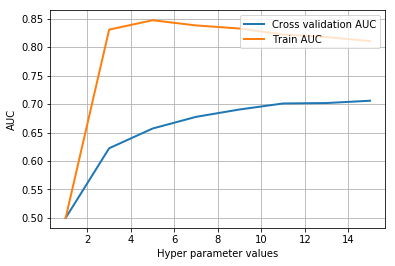

In [ ]:
#plotting the graph 
plt.plot(iterator, cv_auc, linewidth=2)
plt.plot(iterator, train_auc, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Hyper parameter values')
plt.ylabel('AUC')
plt.legend(['Cross validation AUC', 'Train AUC'], loc='upper right')
plt.show()

#### Optimal Hyperparameter is k  = 9

Confusion Matrix on Train 



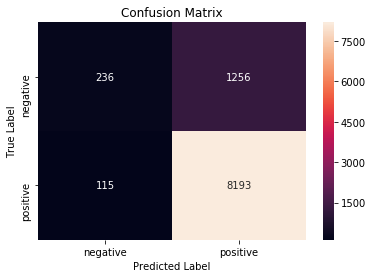

Confusion Matrix on Test 



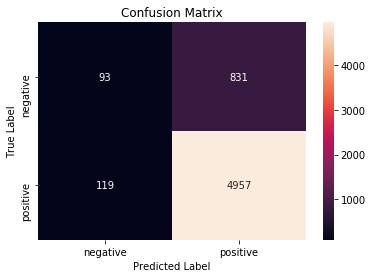

**** TEST AUC ***  0.6848374405998519
**** TRAIN AUC *****  0.8326574179607884


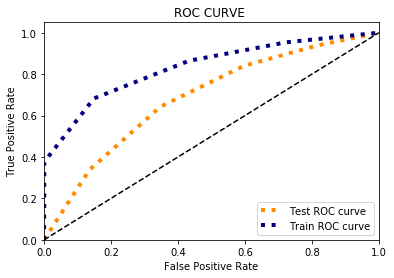

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 9, algorithm  = 'kd_tree' )
clf.fit(tfidf_sent_vectors_tr, y_tr)

predict = clf.predict(tfidf_sent_vectors_tr)
cm = metrics.confusion_matrix(y_tr, predict)
print("Confusion Matrix on Train \n")
ConfusionMatrixPrint(cm)
predict = clf.predict(tfidf_sent_vectors_test)
cm = metrics.confusion_matrix(y_test, predict)
print("Confusion Matrix on Test \n")
ConfusionMatrixPrint(cm)


y_cv_predict = np.array(clf.predict_proba(tfidf_sent_vectors_test))
preds = np.max(y_cv_predict,axis=1)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print("**** TEST AUC *** ", roc_auc)
y_tr_predict = np.array(clf.predict_proba(tfidf_sent_vectors_tr))
y_tr_predict = np.max(y_tr_predict,axis=1)
fpr_tr, tpr_tr, threshold_tr = metrics.roc_curve(y_tr, y_tr_predict)
#calculating AUC
auc = metrics.auc(fpr_tr, tpr_tr)
print("**** TRAIN AUC ***** ", auc)
ROCCurvePrint(fpr,tpr, fpr_tr, tpr_tr)

##<font color='green'><b>Conclusions

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("S.NO",[1,2,3,4,5,6,7,8])
x.add_column("Model Description",["BoW"," TF-IDF"," Avg W2V", " TFIDF W2V", "KD-TREE BoW"," KD-TREE TF-IDF"," KD-TREE Avg W2V", " KD-TREE TFIDF W2V"])
x.add_column("Hyperparameter value",["12","8","13","8","9","11","11","9"])
x.add_column("Test AUC",["66.45" ,"82.46","76.41","74.57","73.39","56.2","73.91","68.43" ])
print(x)

+------+--------------------+----------------------+----------+
| S.NO | Model Description  | Hyperparameter value | Test AUC |
+------+--------------------+----------------------+----------+
|  1   |        BoW         |          12          |  66.45   |
|  2   |       TF-IDF       |          8           |  82.46   |
|  3   |       Avg W2V      |          13          |  76.41   |
|  4   |      TFIDF W2V     |          8           |  74.57   |
|  5   |    KD-TREE BoW     |          9           |  73.39   |
|  6   |   KD-TREE TF-IDF   |          11          |   56.2   |
|  7   |   KD-TREE Avg W2V  |          11          |  73.91   |
|  8   |  KD-TREE TFIDF W2V |          9           |  68.43   |
+------+--------------------+----------------------+----------+
